In [1]:
import sys
sys.path.append('../')
from xd import *
import numpy as np
from utils import *
import esutil
import healpy as hp
from systematics import *
from systematics_module import *

%matplotlib inline

%load_ext autoreload
%autoreload 2

HF = lambda Nr,Nbin: (Nr-Nbin-2) *1./(Nr-1)
HFactor = HF(100, 10)

from systematics_module.corr import angular_correlation_poisson, angular_correlation

In [2]:
def NNpairCount(data, rand, weight_data = None, weight_rand = None, 
    nbins = 20, min_sep = 2.5/60., max_sep = 250/60., bin_slop=0.05, dir = './', suffix=''):
    # cmass and balrog : all systematic correction except obscuration should be applied before passing here
    
    import treecorr
    
    if weight_data : weight_data = data['WEIGHT']
    if weight_rand : weight_rand = rand['WEIGHT_RAND']

    cat = treecorr.Catalog(ra=data['RA'], dec=data['DEC'], w = weight_data, ra_units='deg', dec_units='deg')
    cat_rand = treecorr.Catalog(ra=rand['RA'], dec=rand['DEC'], is_rand=True, w = weight_rand, ra_units='deg', dec_units='deg')
    #nbins = 20
    #bin_size = 0.5
    #min_sep = 2.5/60.
    #max_sep = 250/60.
    sep_units = 'degree'
    #bin_slop = 0.05
    
    dd = treecorr.NNCorrelation(nbins = nbins, max_sep = max_sep, min_sep= min_sep, sep_units=sep_units, bin_slop=bin_slop)
    dr = treecorr.NNCorrelation(nbins = nbins, max_sep = max_sep, min_sep= min_sep, sep_units=sep_units, bin_slop=bin_slop)
    rr = treecorr.NNCorrelation(nbins = nbins, max_sep = max_sep, min_sep= min_sep, sep_units=sep_units, bin_slop=bin_slop)
    
    dd.process(cat)
    dr.process(cat,cat_rand)
    rr.process(cat_rand)
    
    dd.write(dir+'npairs'+suffix+'.txt', rr=rr, dr=dr)
    print 'file save to', dir+'npairs'+suffix+'.txt'
    #xi, varxi = dd.calculateXi(rr,dr)
    #errxi = np.sqrt(varxi)
    
    return dd, dr, rr

In [3]:
def BOSSveto(cat, option='SGC'):
    
    if option == 'SGC':
        valid_hpind = fitsio.read('/n/des/lee.5922/data/cmass_cat/vetomask/mask_nside4096_Patchy-Mocks-Randoms-DR12SGC-COMPSAM_V6C.fits')
    elif option == 'NGC': 
        vetomaskNGC = fitsio.read('/n/des/lee.5922/data/cmass_cat/vetomask/mask_nside4096_Patchy-Mocks-Randoms-DR12NGC-COMPSAM_V6C.fits')

    hpind = hpRaDecToHEALPixel(cat['RA'], cat['DEC'], nside=4096, nest= False)
    HPmask = np.in1d(hpind, valid_hpind)
    
    return cat[HPmask]

In [61]:
#root = '/n/des/lee.5922/data/cmass_cat/dr12_multidark_patchy_mocks/'
basedir = '../data_txt/cmass/'
#cmass_ngc = esutil.io.read(path+'cmass-dr12v4-N-Reid-full.dat.fits')
#cmass_sgc = esutil.io.read(path+'cmass-dr12v4-S-Reid-full.dat.fits')
#cmass_ngc = cmass_ngc[(cmass_ngc['Z'] > 0.43) & (cmass_ngc['Z'] < 0.7)]

cmasspath = '/n/des/lee.5922/data/cmass_cat/'
cmass_ngc = esutil.io.read(cmasspath+'galaxy_DR12v5_CMASS_North.fits.gz')
rand_ngc = esutil.io.read(cmasspath+'random0_DR12v5_CMASS_North.fits.gz')

cmass_sgc = esutil.io.read(cmasspath+'galaxy_DR12v5_CMASS_South.fits.gz')
rand_sgc = esutil.io.read(cmasspath+'random0_DR12v5_CMASS_South.fits.gz')
                          # ,cmasspath+'random1_DR12v5_CMASS_South.fits.gz'
                          #, combine=False)
#cmass_ngc = esutil.io.read(cmasspath+'cmass-dr12v4-N-Reid-full.dat.fits')
#cmass_sgc_reid = esutil.io.read(cmasspath+'cmass-dr12v4-S-Reid-full.dat.fits')



In [19]:
#rand_ngc2 = esutil.io.read(cmasspath+'random1_DR12v5_CMASS_North.fits.gz')
rand_sgc2 = esutil.io.read(cmasspath+'random1_DR12v5_CMASS_South.fits.gz')
rand_sgc2 = appendColumn(cat = rand_sgc2, name='WEIGHT_RAND', value=np.ones(rand_sgc2['WEIGHT_FKP'].size))

In [9]:
cmass_sgc_zcut = cmass_sgc[(cmass_sgc['Z'] > 0.43) & (cmass_sgc['Z'] < 0.7)]
rand_sgc_zcut = rand_sgc[(rand_sgc['Z'] > 0.43) & (rand_sgc['Z'] < 0.7)]

cmass_ngc_zcut = cmass_ngc[(cmass_ngc['Z'] > 0.43) & (cmass_ngc['Z'] < 0.7)]
rand_ngc_zcut = rand_ngc[(rand_ngc['Z'] > 0.43) & (rand_ngc['Z'] < 0.7)]

In [65]:
cmass_weight = cmass_sgc['WEIGHT_SYSTOT']*(cmass_sgc['WEIGHT_CP']+cmass_sgc['WEIGHT_NOZ']-1.)
cmass_sgc = appendColumn(cat = cmass_sgc, name='WEIGHT', value=cmass_weight)
rand_sgc = appendColumn(cat = rand_sgc, name='WEIGHT_RAND', value=np.ones(rand_sgc['WEIGHT_FKP'].size))

In [68]:
cmass_zcut_weight = cmass_sgc_zcut['WEIGHT_FKP'] * cmass_sgc_zcut['WEIGHT_SYSTOT'] * (cmass_sgc_zcut['WEIGHT_CP']+cmass_sgc_zcut['WEIGHT_NOZ']-1.)
cmass_sgc_zcut = appendColumn(cat = cmass_sgc_zcut, name='WEIGHT', value=cmass_zcut_weight)
rand_sgc_zcut = appendColumn(cat = rand_sgc_zcut, name='WEIGHT_RAND', value=rand_sgc_zcut['WEIGHT_FKP'])

ValueError: field 'WEIGHT' occurs more than once

In [20]:
cmass_sgc_veto = BOSSveto(cmass_sgc, option='SGC')
rand_sgc_veto = BOSSveto(rand_sgc, option='SGC')
rand_sgc_veto2 = BOSSveto(rand_sgc2, option='SGC')

In [66]:
cmass_ngc_weight = cmass_ngc['WEIGHT_SYSTOT']*(cmass_ngc['WEIGHT_CP']+cmass_ngc['WEIGHT_NOZ']-1.)
cmass_ngc = appendColumn(cat = cmass_ngc, name='WEIGHT', value=cmass_ngc_weight)
rand_ngc = appendColumn(cat = rand_ngc, name='WEIGHT_RAND', value=np.ones(rand_ngc['WEIGHT_FKP'].size))

ValueError: field 'WEIGHT' occurs more than once

In [11]:
cmass_ngc_zcut_weight = cmass_ngc_zcut['WEIGHT_FKP'] * cmass_ngc_zcut['WEIGHT_SYSTOT'] * (cmass_ngc_zcut['WEIGHT_CP']+cmass_ngc_zcut['WEIGHT_NOZ']-1.)
cmass_ngc_zcut = appendColumn(cat = cmass_ngc_zcut, name='WEIGHT', value=cmass_ngc_zcut_weight)
rand_ngc_zcut = appendColumn(cat = rand_ngc_zcut, name='WEIGHT_RAND', value=rand_ngc_zcut['WEIGHT_FKP'])

In [8]:
# import DMASS
rootdir = '../output/sfd_train_photo_SamPle_nozband_ran10_3_full_tol1e5/'
#dmass = fitsio.read(rootdir+'spt.fits')
#dmass = io.SearchAndCallFits(path = rootdir, keyword='gold_spt_prob')
dmass = io.SearchAndCallFits(path = rootdir, keyword='dmass_spt_sys_v3.fits')
#dmass = dmass[dmass['EachProb_CMASS'] > 0.01]
print 'dmass sample size :', np.sum(dmass['CMASS_PROB'])

dmass = appendColumn(cat = dmass, name='WEIGHT', value=dmass['CMASS_PROB'])
dmass = dmass[dmass['CMASS_PROB'] > 0.01]
#dmass_st82 = appendColumn(cat = dmass_st82, name='WEIGHT', value=dmass_st82['EachProb_CMASS'])
#print np.sum(dmass['EachProb_CMASS']), np.sum(dmass_st82['EachProb_CMASS'])

rand_dmass = io.SearchAndCallFits(path = rootdir, keyword='random_x50_dmass_spt_masked')


--------------------------------
 calling catalog
--------------------------------
dmass_spt_sys_v3.fits
dmass sample size : 120874.72753482158

--------------------------------
 calling catalog
--------------------------------
random_x50_dmass_spt_masked.fits


In [9]:
dmass_pcut = dmass[dmass['CMASS_PROB'] > 0.01]
dmass_pcut_weight = dmass[dmass['CMASS_PROB'] > 0.01]
dmass_pcut_weight['WEIGHT'] = dmass['CMASS_PROB'] * dmass['WEIGHT_SYS']

In [10]:
print 'dmass sample size :', np.sum(dmass['WEIGHT'] )
print 'cmass weighted sample size: ', np.sum(cmass_sgc['WEIGHT'])
print 'cmass sample size:', cmass_sgc.size

dmass sample size : 117292.90214602613
cmass weighted sample size:  249701.58
cmass sample size: 230831


In [75]:
basedir = '../data_txt/random_test/'

In [56]:
dd, dr, rr = NNpairCount(data = cmass_sgc, rand = rand_sgc, 
                    nbins=10, weight_data = True, weight_rand = True, 
                    suffix = '_cmass_sgc', dir = basedir)

randind = np.random.choice(rand_sgc.size, size = rand_sgc.size/5)

dd, dr, rr = NNpairCount(data = cmass_sgc, rand = rand_sgc[randind], 
                    nbins=10, weight_data = True, weight_rand = True, 
                    suffix = '_cmass_sgc_ran5', dir = basedir)

randind2 = np.random.choice(rand_sgc.size, size = rand_sgc.size/10)

dd, dr, rr = NNpairCount(data = cmass_sgc, rand = rand_sgc[randind2], 
                    nbins=10, weight_data = True, weight_rand = True, 
                    suffix = '_cmass_sgc_ran10', dir = basedir)

file save to ../data_txt/cmass/npairs_cmass_sgc.txt
file save to ../data_txt/cmass/npairs_cmass_sgc_ran5.txt
file save to ../data_txt/cmass/npairs_cmass_sgc_ran10.txt


In [31]:
basedir = '../data_txt/cmass/'
ddd, drd, rrd = NNpairCount(data = dmass_pcut_weight, rand = rand_dmass, 
                    nbins=10, weight_data = True, weight_rand = None, 
                    suffix = '_dmass_pcut_sysweight_bins10_binslop_05', dir = basedir)

file save to ../data_txt/cmass/npairs_dmass_pcut_sysweight_bins10_binslop_05.txt


In [42]:
basedir = '../data_txt/cmass/'

randind = np.random.choice(rand_dmass.size, size = rand_dmass.size/4)
ddd, drd, rrd = NNpairCount(data = dmass_pcut_weight, rand = rand_dmass[randind], 
                    nbins=10, weight_data = True, weight_rand = None, 
                    suffix = '_dmass_pcut_sysweight_bins10_binslop_05_ran4', dir = basedir)

file save to ../data_txt/cmass/npairs_dmass_pcut_sysweight_bins10_binslop_05_ran4.txt


In [ ]:
basedir = '../data_txt/cmass/'
dd, dr, rr = NNpairCount(data = cmass_sgc_veto, rand = rand_sgc_veto, 
                    nbins=10, weight_data = True, weight_rand = True, 
                    suffix = '_cmass_sgc_veto', dir = basedir)

In [67]:
basedir = '../data_txt/cmass/'
dd, dr, rr = NNpairCount(data = cmass_sgc, rand = rand_sgc, 
                    nbins=10, weight_data = True, weight_rand = True, 
                    suffix = '_cmass_sgc_bins10_binslop_05', dir = basedir)

file save to ../data_txt/cmass/npairs_cmass_sgc_bins10_binslop_05.txt


In [68]:
basedir = '../data_txt/cmass/'
dd, dr, rr = NNpairCount(data = cmass_ngc, rand = rand_ngc, 
                    nbins=10, weight_data = True, weight_rand = True, 
                    suffix = '_cmass_ngc_bins10_binslop_05', dir = basedir)

file save to ../data_txt/cmass/npairs_cmass_ngc_bins10_binslop_05.txt


In [92]:
basedir = '../data_txt/cmass/'
dd, dr, rr = NNpairCount(data = cmass_ngc, rand = rand_ngc, 
                    nbins=10, bin_slop=0.2, weight_data = True, weight_rand = True, 
                    suffix = '_cmass_ngc_bins10_binslop_2', dir = basedir)

file save to ../data_txt/cmass/npairs_cmass_ngc_bins10_binslop_2.txt


In [56]:
basedir = '../data_txt/cmass/'
randind = np.random.choice(rand_sgc_veto.size, size = rand_sgc_veto.size/5)
dd, dr, rr = NNpairCount(data = cmass_sgc_veto, rand = rand_sgc_veto[randind], 
                    nbins=10, weight_data = True, weight_rand = True, 
                    suffix = '_cmass_sgc_veto_bins10_binslop_05_ran5', dir = basedir)

randind2 = np.random.choice(rand_sgc_veto.size, size = rand_sgc_veto.size/10)

dd, dr, rr = NNpairCount(data = cmass_sgc_veto, rand = rand_sgc_veto[randind2], 
                    nbins=10, weight_data = True, weight_rand = True, 
                    suffix = '_cmass_sgc_veto_bins10_binslop_05_ran10', dir = basedir)

file save to ../data_txt/cmass/npairs_cmass_sgc_veto_bins10_binslop_05_ran5.txt
file save to ../data_txt/cmass/npairs_cmass_sgc_veto_bins10_binslop_05_ran10.txt


In [49]:
randind2 = np.random.choice(rand_sgc_veto.size, size = rand_sgc_veto.size/10)
dd, dr, rr = NNpairCount(data = cmass_sgc_veto, rand = rand_sgc_veto[randind2], 
                    nbins=10, weight_data = True, weight_rand = True, 
                    suffix = '_cmass_sgc_veto_bins10_binslop_01_ran10', dir = basedir)

file save to ../data_txt/cmass/npairs_cmass_sgc_veto_bins10_binslop_01_ran10.txt


In [22]:
randx2 = np.hstack((rand_sgc_veto, rand_sgc_veto2))

In [23]:
dd, dr, rr = NNpairCount(data = cmass_sgc_veto, rand = randx2, 
                    nbins=10, weight_data = True, weight_rand = True, 
                    suffix = '_cmass_sgc_veto_bins10_binslop_05_ranx2', dir = basedir)

file save to ../data_txt/cmass/npairs_cmass_sgc_veto_bins10_binslop_05_ranx2.txt


In [ ]:
theta, _, _, xi, sigma_xi, _,_,_,_ = np.genfromtxt('../data_txt/cmass/npairs_cmass_sgc_veto_bins10_binslop_01.txt', unpack=True)
fig, ax = plt.subplots()
ax.loglog(theta, xi)

In [74]:
dd, dr, rr = NNpairCount(data = cmass_sgc, rand = rand_sgc2, 
                    nbins=10, weight_data = True, weight_rand = None, 
                    suffix = '_cmass_sgc2', dir = basedir)

file save to ../data_txt/cmass/npairs_cmass_sgc2.txt


In [154]:
dd, dr, rr = NNpairCount(data = reid_cmass_sgc, rand = reid_rand_sgc, 
                    nbins=10, weight_data = True, weight_rand = True, 
                    suffix = '_cmass_sgc_reid', dir = basedir)

file save to ../data_txt/cmass/npairs_cmass_sgc_reid.txt


In [122]:
dd, dr, rr = NNpairCount(data = cmass_sgc, rand = rand_sgc, 
                    nbins=10, weight_data = None, weight_rand = None, 
                    suffix = '_cmass_sgc_no_weight', dir = basedir)

file save to ../data_txt/cmass/npairs_cmass_sgc_no_weight.txt


In [58]:
dd, dr, rr = NNpairCount(data = cmass_ngc, rand = rand_ngc, 
                    nbins=10, weight_data = True, weight_rand = True, 
                    suffix = '_cmass_ngc', dir = basedir)

randind = np.random.choice(rand_ngc.size, size = rand_ngc.size/5)

dd, dr, rr = NNpairCount(data = cmass_ngc, rand = rand_ngc[randind], 
                    nbins=10, weight_data = True, weight_rand = True, 
                    suffix = '_cmass_ngc_ran5', dir = basedir)

randind2 = np.random.choice(rand_ngc.size, size = rand_ngc.size/10)

dd, dr, rr = NNpairCount(data = cmass_ngc, rand = rand_ngc[randind2], 
                    nbins=10, weight_data = True, weight_rand = True, 
                    suffix = '_cmass_ngc_ran10', dir = basedir)

file save to ../data_txt/cmass/npairs_cmass_ngc.txt
file save to ../data_txt/cmass/npairs_cmass_ngc_ran5.txt
file save to ../data_txt/cmass/npairs_cmass_ngc_ran10.txt


In [ ]:
dd, dr, rr = NNpairCount(data = cmass_ngc, rand = rand_ngc, 
                    nbins=10, weight_data = True, weight_rand = True, 
                    suffix = '_cmass_ngc', dir = basedir)



In [125]:
dd, dr, rr = NNpairCount(data = cmass_ngc, rand = rand_ngc, 
                    nbins=10, weight_data = None, weight_rand = None, 
                    suffix = '_cmass_ngc_no_weight', dir = basedir)

file save to ../data_txt/cmass/npairs_cmass_ngc_no_weight.txt


In [ ]:
angular_correlation(data = cmass_sgc, rand = rand_sgc, 
                    nbins=10, weight = [True, True], njack = 100, 
                    suffix = '_DR12v5_CMASS_South_bins10_jk100', dir = basedir)

calculate angular correlation function
generate new jkregion : ../data_txt/random_test/./jkregion.txt
X (1000, 2)  centers (100, 2)  tol=1e-05  maxiter=200
13 iterations  cluster sizes: [11 10  9  9  7 18  8  8 21 10 11 11 11  4 13 15  7 10 10 12 12  9 16 14
 10 12  4 18  5  5  9  8  6 13  9 10 11 12  8 14 12 18  9 10 13 10  1  6
  9 11 20  8  5  7 16 11  8  6 11  6 14  8 13  8  8  7  8  5 11 11  7  7
 13 15  4 11  7 11  9  9 14  5  8 14  8 10 11  7 11 13  3  6 14  6  6 14
 11  9 10 17]
X (230831, 2)  centers (100, 2)  tol=1e-05  maxiter=200


In [36]:
angular_correlation(data = cmass_sgc, rand = rand_sgc, 
                    nbins=10, weight = [True, True], njack = 50, 
                    suffix = '_DR12v5_CMASS_South_bins10_jk50', dir = basedir)

calculate angular correlation function
exiting jkregion file found : ../data_txt/random_test/./jkregion.txt
generate new jkregion : ../data_txt/random_test/./jkregion.txt
X (960, 2)  centers (50, 2)  tol=1e-05  maxiter=200
16 iterations  cluster sizes: [28 11 13 15 18 25 23 18 17 16 24 26 17 14 14 23 17 15 24 12 20 14 16 27
 26 24 23 15 28 13 22 19 16 17 12 13 25 23 17 18 13 14 23 23 14 16 18 20
 18 43]
X (230831, 2)  centers (50, 2)  tol=1e-05  maxiter=200
156 iterations  cluster sizes: [4951 4395 4846 4033 5093 4068 4207 4871 4532 4581 4271 4602 4336 4101
 4515 4813 3664 4242 5023 4637 4685 4360 4517 4409 3998 4864 4097 4696
 5099 5086 5456 5115 5286 3695 4906 5282 5664 4610 4864 5066 3241 5235
 4547 4724 4408 2999 4995 4929 4917 5300]
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . saving data file to :  ../data_txt/random_test//acf_auto_DR12v5_CMASS_South_bins10_jk50.txt


In [ ]:
angular_correlation(data = cmass_sgc, rand = rand_sgc, 
                    nbins=20, weight = [True, True], njack = 100, 
                    suffix = '_DR12v5_CMASS_South_bins20_jk100', dir = basedir)

In [ ]:
randind = np.random.choice(rand_sgc.size, size = rand_sgc.size/5)
angular_correlation(data = cmass_sgc, rand = rand_sgc[randind], 
                    nbins=10, weight = [True, True], njack = 100, 
                    suffix = '_DR12v5_CMASS_South_ran5_bins10_jk100', dir = basedir)

randind2 = np.random.choice(rand_sgc.size, size = rand_sgc.size/10)
angular_correlation(data = cmass_sgc, rand = rand_sgc[randind2], 
                    nbins=10, weight = [True, True], njack = 100, 
                    suffix = '_DR12v5_CMASS_South_ran10_bins10_jk100', dir = basedir)

In [25]:
angular_correlation(data = dmass, rand = rand_dmass, 
                    nbins=10, weight = [True, None], njack = 50, 
                    suffix = '_dmass_bins10_jk100', dir = basedir)
angular_correlation(data = dmass_pcut, rand = rand_dmass, 
                    nbins=10, weight = [True, None], njack = 50, 
                    suffix = '_dmass_pcut_bins10_jk100', dir = basedir)
angular_correlation(data = dmass_pcut_weight, rand = rand_dmass, 
                    nbins=10, weight = [True, None], njack = 50, 
                    suffix = '_dmass_pcut_weight_bins10_jk100', dir = basedir)

calculate angular correlation function
exiting jkregion file found : ../data_txt/random_test/./jkregion.txt
generate new jkregion : ../data_txt/random_test/./jkregion.txt
X (1656, 2)  centers (50, 2)  tol=1e-05  maxiter=200
18 iterations  cluster sizes: [27 22 23 30 15 34 20 44 24 37 31 37 24 23 49 16 47 20 56 25 37 29 20 36
 29 28 31 42 45 24 55 51 36 23 54 31 15 28 38 55 43 30 42 10 45 34 30 43
 45 23]
X (685616, 2)  centers (50, 2)  tol=1e-05  maxiter=200
45 iterations  cluster sizes: [10756 13034 11498 12218 10348 13960 13826 14041 12353 18424 13190 16086
 11536 13840 18695 10487 11167 11525 13918 14643 15805 15023 13402 13850
 15287  9400 16049 13108 14154 12414 18938 18070 13939 15693 17362 11336
  7437 13435  8863 20362 15354 12804 16176  5636 15074 14054 12928 17014
 13675 13429]
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . saving data file to :  ../data_txt/random_test//acf_auto_dmass_bins10_jk100.txt
calculate angular c

In [24]:
cmass_sgc_data1 = np.genfromtxt('../data_txt/cmass/npairs_cmass_sgc_bins10_binslop_05.txt')
#cmass_sgc_data2 = np.genfromtxt('../data_txt/random_test/npairs_cmass_sgc_ran5.txt')
cmass_sgc_data2 = np.genfromtxt('../data_txt/cmass/npairs_cmass_sgc_veto_bins10_binslop_05_ran5.txt')
#cmass_sgc_data3 = np.genfromtxt('../data_txt/random_test/npairs_cmass_sgc_ran10.txt')
cmass_sgc_data3 = np.genfromtxt('../data_txt/cmass/npairs_cmass_sgc_veto_bins10_binslop_05_ran10.txt')
cmass_sgc_data4 = np.genfromtxt('../data_txt/cmass/npairs_cmass_sgc_veto_bins10_binslop_05_ranx2.txt')
cmass_sgc_data5 = np.genfromtxt('../data_txt/random_test/npairs_cmass_sgc_no_weight.txt')
cmass_sgc_data6 = np.genfromtxt('../data_txt/random_test/npairs_cmass_sgc_reid.txt')
cmass_sgc_data7 = np.genfromtxt('../data_txt/random_test/npairs_cmass_sgc_veto.txt')
cmass_sgc_data8 = np.genfromtxt('../data_txt/cmass/npairs_cmass_sgc_veto_bins10_binslop_1.txt')
cmass_sgc_data9 = np.genfromtxt('../data_txt/cmass/npairs_cmass_sgc_veto_bins10_binslop_05.txt')
#cmass_sgc_data10 = np.genfromtxt('../data_txt/cmass/npairs_cmass_sgc_veto_bins10_binslop_01.txt')

theta, _, _, xi_sgc1, sigma_xi_sgc1, DD, RR, DR, npairs = [cmass_sgc_data1[:,i] for i in range(9)]
theta, _, _, xi_sgc2, sigma_xi_sgc2, DD2, RR2, DR2, npairs2 = [cmass_sgc_data2[:,i] for i in range(9)]
theta, _, _, xi_sgc3, sigma_xi_sgc3, DD3, RR3, DR3, npairs3 = [cmass_sgc_data3[:,i] for i in range(9)]
theta, _, _, xi_sgc4, sigma_xi_sgc4, DD4, RR4, DR4, npairs4 = [cmass_sgc_data4[:,i] for i in range(9)]
theta, _, _, xi_sgc5, sigma_xi_sgc5, DD5, RR5, DR5, npairs5 = [cmass_sgc_data5[:,i] for i in range(9)]
theta, _, _, xi_sgc6, sigma_xi_sgc6, DD6, RR6, DR6, npairs6 = [cmass_sgc_data6[:,i] for i in range(9)]
theta, _, _, xi_sgc7, sigma_xi_sgc7, DD7, RR7, DR7, npairs7 = [cmass_sgc_data7[:,i] for i in range(9)]
theta8, _, _, xi_sgc8, sigma_xi_sgc8, DD8, RR8, DR8, npairs8 = [cmass_sgc_data8[:,i] for i in range(9)]
theta9, _, _, xi_sgc9, sigma_xi_sgc9, DD9, RR9, DR9, npairs9 = [cmass_sgc_data9[:,i] for i in range(9)]
#theta10, _, _, xi_sgc10, sigma_xi_sgc10, DD10, RR10, DR10, npairs10 = [cmass_sgc_data10[:,i] for i in range(9)]


cmass_ngc_data1 = np.genfromtxt('../data_txt/cmass/npairs_cmass_ngc_bins10_binslop_2.txt')
cmass_ngc_data2 = np.genfromtxt('../data_txt/cmass/npairs_cmass_ngc_bins10_binslop_05.txt')
#cmass_ngc_data3 = np.genfromtxt('../data_txt/random_test/npairs_cmass_ngc_ran10.txt')
#cmass_ngc_data5 = np.genfromtxt('../data_txt/random_test/npairs_cmass_ngc_no_weight.txt')
theta, _, _, xi_ngc1, sigma_xi_ngc1, _, _, _, _ = [cmass_ngc_data1[:,i] for i in range(9)]
theta, _, _, xi_ngc2, sigma_xi_ngc2, _, _, _, _ = [cmass_ngc_data2[:,i] for i in range(9)]

#theta, xi_ngc1, sigma_xi_ngc1 = cmass_ngc_data1[:,0], cmass_ngc_data1[:,3], cmass_ngc_data1[:,4]
#theta, xi_ngc2, sigma_xi_ngc2 = cmass_ngc_data2[:,0], cmass_ngc_data2[:,3], cmass_ngc_data2[:,4]
#theta, xi_ngc3, sigma_xi_ngc3 = cmass_ngc_data3[:,0], cmass_ngc_data3[:,3], cmass_ngc_data3[:,4]
#theta, _, _, xi_ngc5, sigma_xi_ngc5, DDN5, RRN5, DRN5, npairsN5 = [cmass_ngc_data5[:,i] for i in range(9)]


cmass_sgc_data = np.genfromtxt('../data_txt/cmass/npairs_cmass_sgc_bins10_binslop_05.txt')
#cmass_sgc_data = np.genfromtxt('../data_txt/cmass/npairs_DR12v5_CMASS_South_10bins_binslop_01.txt')
_, meanr_sgc_new, _, xi_sgc_new, sigma_xi_sgc_new, DD_sgc, RR_sgc, DR_sgc, npairs_sgc = [cmass_sgc_data[:,i] for i in range(9)]

cmass_ngc_data1 = np.genfromtxt('../data_txt/cmass/npairs_cmass_ngc_bins10_binslop_05.txt')
_, meanr_ngc_new, _, xi_ngc_new, sigma_xi_ngc_new, DD_ngc, RR_ngc, DR_ngc, npairs_ngc = [cmass_ngc_data1[:,i] for i in range(9)]

cmass_full_data = np.genfromtxt('../data_txt/cmass/npairs_cmass_combined_ngc_sgc_bins10_binslop_05.txt')
_, meanr_full_new, _, xi_full_new, sigma_xi_full_new, _, _, _, _ = [cmass_full_data[:,i] for i in range(9)]


meanr_sgc_old, xi_sgc_old, sigma_xi_sgc_old = np.loadtxt('../data_txt//acf_auto_cmass_sgc_sys_cp_nz_weight_nbins10_jk100.txt',unpack=True)
meanr_full_old, xi_full_old, sigma_xi_full_old = np.loadtxt('../data_txt//acf_auto_cmass_full_sys_cp_nz_weight_nbins10_jk100.txt',unpack=True)



In [5]:
theta, xi_sgc_jk100, xi_sigma_sgc_jk100 = \
np.genfromtxt('../data_txt/random_test/acf_auto_DR12v5_CMASS_South_bins10_jk100.txt', unpack=True)
theta2, xi_dmass1, xi_sigma_dmass1 = \
np.genfromtxt('../data_txt/random_test//acf_auto_dmass_bins10_jk100.txt', unpack=True)
theta2, xi_dmass2, xi_sigma_dmass2 = \
np.genfromtxt('../data_txt/random_test/acf_auto_dmass_pcut_bins10_jk100.txt', unpack=True)
#theta_old, xi_dmass_old, xi_sigma_dmass_old = \
#np.genfromtxt('../data_txt/random_test/acf_auto_dmass_pcut_weight_bins10_jk100.txt', unpack=True)
#theta_old, xi_dmass_old, xi_sigma_dmass_old = \
#np.genfromtxt('../data_txt/random_test/acf_auto_dmass_pcut_weight_bins10_jk100.txt', unpack=True)

rootdir = '../output/sfd_train_photo_SamPle_nozband_ran10_3_full_tol1e5//act/'
theta_old, xi_dmass_old, xi_sigma_dmass_old = np.genfromtxt(rootdir+'acf_auto_dmass_all_weight_pcut01_nbins10_jk100.txt', unpack=True) 

dmass_data = np.genfromtxt('../data_txt/cmass/npairs_dmass_pcut_sysweight_bins10_binslop_05.txt')
theta2, theta_mean2, _, xi_dmass2, xi_sigma_dmass2, _, _, _, _ = [dmass_data[:,i] for i in range(9)]

#dmass_data = np.genfromtxt('../data_txt/cmass/npairs_dmass_pcut_sysweight_bins10_binslop_05_ran4.txt')
#theta2, theta_mean2, _, xi_dmass2, xi_sigma_dmass2, _, _, _, _ = [dmass_data[:,i] for i in range(9)]


In [6]:
cov_mocks = np.genfromtxt('../data_txt/mocks/cov_mock_galaxy_DR12_CMASS_S_QPM_760.cov')
cov_mocks_ngc = np.genfromtxt('../data_txt/mocks/cov_mock_galaxy_DR12_CMASS_N_QPM_656.cov')
cov_mocks_full = np.linalg.inv(np.linalg.inv( cov_mocks ) + np.linalg.inv( cov_mocks_ngc ))
cov_rescaled_mocks = np.genfromtxt('../data_txt/cmass/cov_rescaled_mocks_NG.txt')


sigma_sgc_mock = np.sqrt(cov_mocks.diagonal())
sigma_dmass_mock = np.sqrt(cov_rescaled_mocks.diagonal())
sigma_full_mock = np.sqrt(cov_mocks_full.diagonal())

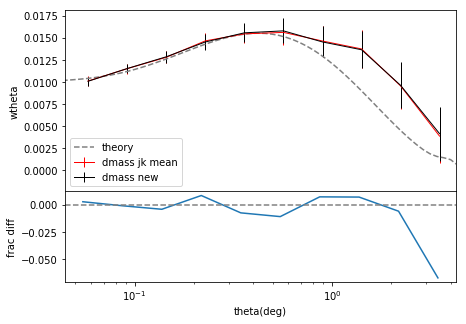

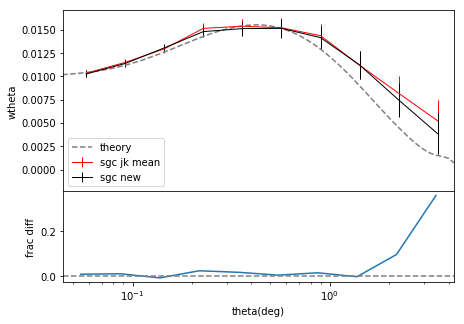

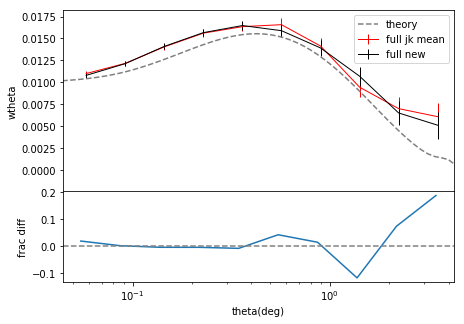

In [25]:
meanr_sgc, xi_sgc_origin, xi_err_sgc_origin = np.loadtxt('../data_txt//acf_auto_cmass_sgc_sys_cp_nz_weight_nbins10_jk100.txt',unpack=True)
#cov_cmass_s = np.genfromtxt('../data_txt//acf_auto_cmass_sgc_sys_cp_nz_weight_nbins10_jk100.cov')

theta_th, theory_sgc = np.loadtxt('../data_txt/acf_cmass_sgc_theory.txt', unpack=True)


fig, (ax, ax2) = plt.subplots(2, 1, figsize = (7, 5), gridspec_kw = {'height_ratios':[2, 1]})
ax.plot( theta_th, theta_th*theory_sgc, color = 'grey', ls='--', label='theory')
#ax.errorbar( meanr_sgc, xi_sgc_origin, yerr = xi_err_sgc_origin, color = 'k', label='SGC origin')
ax.errorbar(theta_old, theta_old*xi_dmass_old, yerr = theta_old*sigma_dmass_mock, color = 'red', lw = 1, label='dmass jk mean')
ax.errorbar(theta_mean2, theta_mean2*xi_dmass2, yerr = theta_mean2*sigma_dmass_mock, color = 'black', lw = 1, label='dmass new')

ax.set_xlim(2.5/60., 250/60.)
#ax.set_ylim(0, 0.3)

ax2.set_xlabel('theta(deg)')
ax.set_ylabel('wtheta')
ax.set_xscale('log')
#ax.set_yscale('log')
ax.legend()

ax2.plot(theta_old, (xi_dmass_old -xi_dmass2)/xi_dmass2 )
ax2.axhline(y=0, color='grey', ls='--')
ax2.set_xscale('log')
ax2.set_ylabel('frac diff')
fig.subplots_adjust(hspace=0.0);


fig, (ax, ax2) = plt.subplots(2, 1, figsize = (7, 5), gridspec_kw = {'height_ratios':[2, 1]})
ax.plot( theta_th, theta_th*theory_sgc, color = 'grey', ls='--', label='theory')
#ax.errorbar( meanr_sgc, xi_sgc_origin, yerr = xi_err_sgc_origin, color = 'k', label='SGC origin')
ax.errorbar(meanr_sgc_old, meanr_sgc_old*xi_sgc_old, yerr = meanr_sgc_old*sigma_sgc_mock, color = 'red', lw = 1, label='sgc jk mean')
ax.errorbar(meanr_sgc_new, meanr_sgc_old*xi_sgc_new, yerr = meanr_sgc_old*sigma_sgc_mock, color = 'black', lw = 1, label='sgc new')

ax.set_xlim(2.5/60., 250/60.)
#ax.set_ylim(0, 0.3)

ax2.set_xlabel('theta(deg)')
ax.set_ylabel('wtheta')
ax.set_xscale('log')
#ax.set_yscale('log')
ax.legend()

ax2.plot(meanr_sgc_old, (xi_sgc_old -xi_sgc_new)/xi_sgc_new )
ax2.axhline(y=0, color='grey', ls='--')
ax2.set_xscale('log')
ax2.set_ylabel('frac diff')
fig.subplots_adjust(hspace=0.0);

fig, (ax, ax2) = plt.subplots(2, 1, figsize = (7,5), gridspec_kw = {'height_ratios':[2, 1]})
ax.plot( theta_th, theta_th*theory_sgc, color = 'grey', ls='--', label='theory')
#ax.errorbar( meanr_sgc, xi_sgc_origin, yerr = xi_err_sgc_origin, color = 'k', label='SGC origin')
ax.errorbar(meanr_full_old, meanr_full_old*xi_full_old, yerr = meanr_full_old*sigma_full_mock, color = 'red', lw = 1, label='full jk mean')
ax.errorbar(meanr_full_new, meanr_full_new*xi_full_new, yerr = meanr_full_new*sigma_full_mock, color = 'black', lw = 1, label='full new')

ax.set_xlim(2.5/60., 250/60.)
#ax.set_ylim(0, 0.3)

ax2.set_xlabel('theta(deg)')
ax.set_ylabel('wtheta')
ax.set_xscale('log')
#ax.set_yscale('log')
ax.legend()

ax2.plot(meanr_full_old, (xi_full_old -xi_full_new)/xi_full_new )
ax2.axhline(y=0, color='grey', ls='--')
ax2.set_xscale('log')
ax2.set_ylabel('frac diff')

fig.subplots_adjust(hspace=0.0);

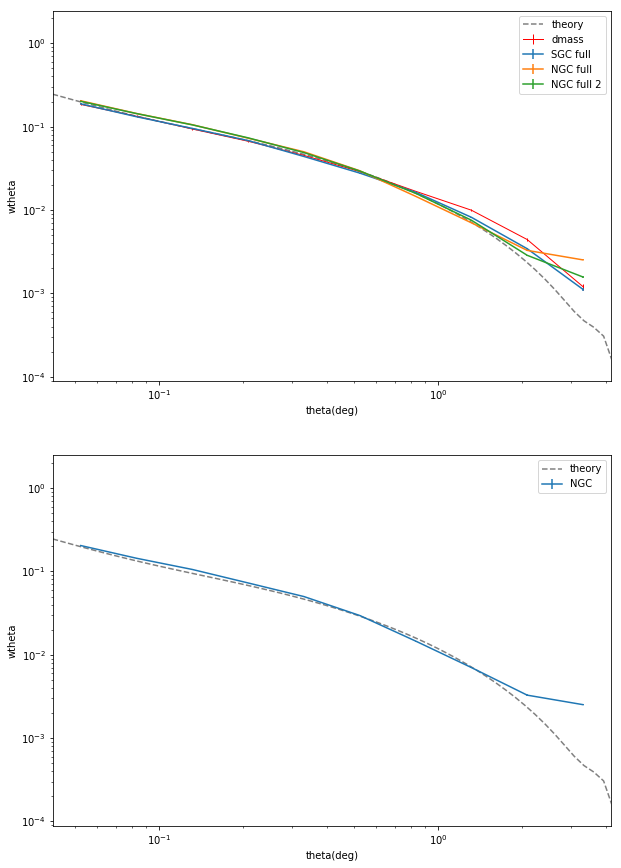

In [94]:

meanr_sgc, xi_sgc_origin, xi_err_sgc_origin = np.loadtxt('../data_txt//acf_auto_cmass_sgc_sys_cp_nz_weight_nbins10_jk100.txt',unpack=True)
#cov_cmass_s = np.genfromtxt('../data_txt//acf_auto_cmass_sgc_sys_cp_nz_weight_nbins10_jk100.cov')

theta_th, theory_sgc = np.loadtxt('../data_txt/acf_cmass_sgc_theory.txt', unpack=True)


fig, (ax, ax2) = plt.subplots(2,1, figsize = (10,15))
ax.plot( theta_th, theory_sgc, color = 'grey', ls='--', label='theory')
#ax.errorbar( meanr_sgc, xi_sgc_origin, yerr = xi_err_sgc_origin, color = 'k', label='SGC origin')
ax.errorbar(theta2, xi_dmass, yerr = xi_sigma_dmass, color = 'red', lw = 1, label='dmass')
#ax.errorbar(theta2, xi_dmass2, yerr = xi_sigma_dmass2, color = 'red', lw = 1, label='dmass ran4')
#ax.plot( theta_th, theory_sgc, color = 'grey', ls='--', label='theory')
#ax.plot( R_mean, dmass_xi, label='DMASS')
ax.errorbar( theta, xi_sgc1, yerr = sigma_xi_sgc1, label='SGC full')
ax.errorbar( theta, xi_ngc1, yerr = sigma_xi_ngc1, label='NGC full')
ax.errorbar( theta, xi_ngc2, yerr = sigma_xi_ngc2, label='NGC full 2')
#ax.errorbar( theta, xi_sgc2, yerr = sigma_xi_sgc2, label='SGC ran5')
#ax.errorbar( theta, xi_sgc3, yerr = sigma_xi_sgc3, label='SGC ran10')
#ax.errorbar( theta, xi_sgc4, yerr = sigma_xi_sgc4, fmt='--',  label='SGC ran x2')
#ax.errorbar( theta, xi_sgc6, yerr = sigma_xi_sgc6, label='SGC reid')
#ax.errorbar( theta8, xi_sgc8, yerr = sigma_xi_sgc8, label='SGC veto binslop')
#ax.errorbar( theta8, xi_sgc9, yerr = sigma_xi_sgc9, fmt='--', label='SGC veto binslop 05')
#ax.errorbar( theta8, xi_sgc10, yerr = sigma_xi_sgc10, label='SGC veto binslop 01')

#ax.errorbar(theta, xi_sgc_jk100, yerr = xi_sigma_sgc_jk100, label='jk100')


ax.set_xlim(2.5/60., 250/60.)
#ax.set_ylim(0, 0.3)

ax.set_xlabel('theta(deg)')
ax.set_ylabel('wtheta')
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend()


ax2.plot( theta_th, theory_sgc, color = 'grey', ls='--', label='theory')
#ax.plot( theta_th, theory_sgc, color = 'grey', ls='--', label='theory')
#ax.plot( R_mean, dmass_xi, label='DMASS')
ax2.errorbar( theta, xi_ngc1, yerr = sigma_xi_sgc1, label='NGC')
#ax2.errorbar( theta, xi_ngc2, yerr = sigma_xi_sgc2, label='NGC ran5')
#ax2.errorbar( theta, xi_ngc3, yerr = sigma_xi_sgc3, label='NGC ran10')
 
ax2.set_xlim(2.5/60., 250/60.)
#ax.set_ylim(0, 0.3)

ax2.set_xlabel('theta(deg)')
ax2.set_ylabel('wtheta')
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.legend()

